In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.optimize import least_squares
from functools import partial

from IPython.display import HTML

In [2]:
import os

output_dir = "out/"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## Načtení dat


In [3]:
data = pd.read_csv("logs/positions.csv")

data.head()

,id,idx,x,y,comment
0,9,8,10.473627,-4.045105,localization
1,8,7,10.197010,3.665844,localization
2,7,6,5.906242,1.653850,localization
3,6,5,6.071673,1.856514,localization
4,4,4,-7.756449,2.706479,localization


In [4]:
colors = pd.read_csv("logs/colors.csv")
data = pd.merge(data, colors, on="id", how="outer")
data.head()

,id,idx,x,y,comment,color
0,1,1,0.0,0.0,localization,ff0000
1,1,1,0.0,0.0,final,ff0000
2,1,1,0.0,0.0,real,ff0000
3,2,2,3.0,0.0,localization,00ff00
4,2,2,3.0,0.0,final,00ff00


In [5]:
localization = data[data["comment"] == "localization"]
final = data[data["comment"] == "final"]
real = data[data["comment"] == "real"]

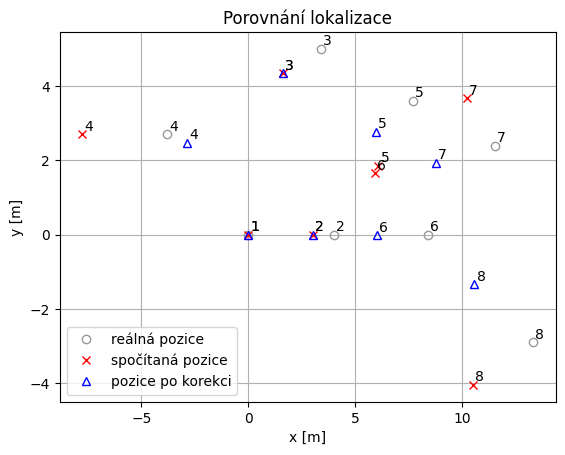

In [6]:
fig, ax = plt.subplots()
ax.plot(real["x"], real["y"],"o", fillstyle="none", color="0.6", label="reálná pozice")
ax.plot(localization["x"], localization["y"],"xr", label="spočítaná pozice")
ax.plot(final["x"], final["y"],"^b", fillstyle="none", label="pozice po korekci")
for i in range(data.shape[0]):
    ax.annotate(data.iloc[i]["idx"], (data.iloc[i]["x"] + 0.1,data.iloc[i]["y"] + 0.1))
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Porovnání lokalizace')
ax.grid()
plt.show()
fig.savefig(f"{output_dir}finding-color-locations.png", dpi=300)

In [7]:
def draw_multilateration(data, alt_data, colors=["black","red","green","blue","orange","yellow","deepskyblue","pink"]):
    color_idx = 0
    fig, ax = plt.subplots()
    ax.plot(alt_data["x"], alt_data["y"],"o", color="0.6")
    for i in range(alt_data.shape[0]):
        ax.annotate(alt_data.iloc[i]["id"], (alt_data.iloc[i]["x"],alt_data.iloc[i]["y"]))
    for i in range(data.shape[0]):
        ax.plot(data.iloc[i]["x"], data.iloc[i]["y"],"o",color=colors[color_idx])
        ax.annotate(data.iloc[i]["id"], (data.iloc[i]["x"],data.iloc[i]["y"]))
        if data.iloc[i]["dist"] != np.nan:
            ax.add_patch(plt.Circle((data.iloc[i]["x"],data.iloc[i]["y"]), data.iloc[i]["dist"], alpha=0.08, color=colors[color_idx]))
            ax.add_patch(plt.Circle((data.iloc[i]["x"],data.iloc[i]["y"]), data.iloc[i]["dist"], fill=False, color=colors[color_idx]))
        color_idx += 1
        if color_idx >= len(colors):
            color_idx = 0
    ax.set_aspect('equal', adjustable='box')

In [8]:
def make_equations(anchors):
    if len(anchors) < 2:
        return None, None
    A = np.ndarray((len(anchors)-1, 2))
    b = np.ndarray((len(anchors)-1))
    for i in range(1,len(anchors)):
        A[i-1, 0] = anchors[i]["x"] - anchors[0]["x"]
        A[i-1, 1] = anchors[i]["y"] - anchors[0]["y"]
        b[i-1] = 0.5 * (anchors[0]["dist"]**2 - anchors[i]["dist"]**2 + (anchors[i]["x"]**2 + anchors[i]["y"]**2) - (anchors[0]["x"]**2 + anchors[0]["y"]**2))
    return A, b

In [9]:
def draw_multilateration_equations(anchors, pos, fig=None, ax=None, border=5, colors=["black","red","green","blue","orange","yellow","deepskyblue","pink"]):
    A, b = make_equations(anchors)
    if A is None or b is None:
        return None, None
    color_idx = 0
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    for i,anchor in enumerate(anchors):
        ax.plot(anchor["x"], anchor["y"],"o",color=colors[color_idx])
        ax.annotate(i, (anchor["x"],anchor["y"]))
        # draw circles
        ax.add_patch(plt.Circle((anchor["x"],anchor["y"]), anchor["dist"], alpha=0.08, color=colors[color_idx]))
        ax.add_patch(plt.Circle((anchor["x"],anchor["y"]), anchor["dist"], fill=False, color=colors[color_idx]))
        # draw linear equations
        if i != 0:
            if A[i-1,0] == 0:
                x_intercept = b[i-1]/0.000000001 # approximation
            else:
                x_intercept = b[i-1]/A[i-1,0]
            if A[i-1,1] == 0:
                y_intercept = b[i-1]/0.000000001 # approximation
            else:
                y_intercept = b[i-1]/A[i-1,1]
            ax.axline((0, y_intercept), (x_intercept,0), color=colors[color_idx])
            print(f"A={A[i-1]}, b = {b[i-1]}")
            print(f"{(0, y_intercept)}, {(x_intercept,0)}, color={colors[color_idx]}")
        color_idx += 1
        if color_idx >= len(colors):
            color_idx = 0
    ax.plot(pos[0], pos[1], "*", markersize=10, markerfacecolor="yellow", markeredgewidth=1, markeredgecolor="black", label="výsledek multilaterace")
    ax.set_aspect('equal', adjustable='box')
    
    # custom bounds
    x_limits = [pos[0], pos[0]]
    y_limits = [pos[1], pos[1]]
    for anchor in anchors:
        x_limits[0] = min(x_limits[0], anchor["x"] - anchor["dist"])
        x_limits[1] = max(x_limits[1], anchor["x"] + anchor["dist"])
        y_limits[0] = min(y_limits[0], anchor["y"] - anchor["dist"])
        y_limits[1] = max(y_limits[1], anchor["y"] + anchor["dist"])
    ax.set_xlim((x_limits[0] - border, x_limits[1] + border))
    ax.set_ylim((y_limits[0] - border, y_limits[1] + border))
    ax.legend()
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    return fig, ax

In [10]:
# Levenberg-Marquardt Non-linear least squares
def lma(anchors):
    def jacobian(locs, x):
        dxy = (locs[:,0] - x[0])**2 + (locs[:,1] - x[1])**2
        dxy[dxy == 0] = 1e-6
        return (locs - x) / np.sqrt(dxy).reshape(-1,1)
    def residuals(locs, dists, x):
        return dists - np.sqrt((locs[:,0] - x[0])**2 + (locs[:,1] - x[1])**2)
    locations = np.ndarray((len(anchors), 2))
    distances = np.ndarray((len(anchors)))
    for i,anchor in enumerate(anchors):
        locations[i,0] = anchor["x"]
        locations[i,1] = anchor["y"]
        distances[i] = anchor["dist"]
    
    # make initial guess - average of x and y coordinates of 2 closest anchors
    sorted_dists_idx = np.argsort(distances)
    x0 = (locations[sorted_dists_idx[0]][0] + locations[sorted_dists_idx[1]][0])/2
    y0 = (locations[sorted_dists_idx[0]][1] + locations[sorted_dists_idx[1]][1])/2

    res = least_squares(partial(residuals, locations, distances), np.array([x0, y0]), partial(jacobian, locations), method="lm")
    return res.x

In [11]:
anchor_good = pd.read_json("logs/001a.json")
print(f"{anchor_good.shape=}")
anchor_good.head(2)

anchor_good.shape=(30, 6)


,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos,current_color
0,3041070,3041350,[],[],"[0.0, 0.0]",NaN
1,3041980,3042320,"[{'x': 6.01, 'y': -0.01, 'dist': 2.45}, {'x': ...","[{'x': 6.01, 'y': -0.01, 'dist': 2.45}, {'x': ...","[10.19701, 3.665844]",NaN


A=[-0.04  2.78], b = 0.5079999999999956
(0, 0.1827338129496387), (-12.699999999999878, 0), color=red
A=[-3.01  0.01], b = -27.787300000000002
(0, -2778.73), (9.231661129568108, 0), color=green
A=[-4.41  4.35], b = -23.088250000000002
(0, -5.307643678160921), (5.235430839002268, 0), color=blue
A=[-6.01  0.01], b = -66.9769
(0, -6697.69), (11.144242928452579, 0), color=orange


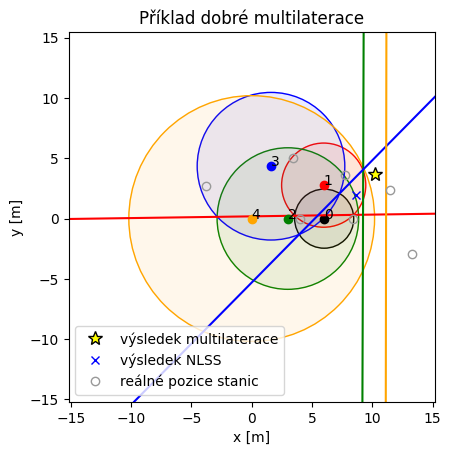

In [12]:
fig,ax = draw_multilateration_equations(anchor_good.iloc[-1]["chosen_anchors"], anchor_good.iloc[-1]["result_pos"])
lma_pos = lma(anchor_good.iloc[-1]["chosen_anchors"])
ax.plot(lma_pos[0], lma_pos[1], "xb", label="výsledek NLSS")
ax.plot(real.iloc[-7:]["x"], real.iloc[-7:]["y"], "o", fillstyle="none", color="0.6", label="reálné pozice stanic")
ax.legend()
ax.set_title("Příklad dobré multilaterace")
fig.savefig(f"{output_dir}finding-color-localization-error.png", dpi=300)

In [13]:
anchor_outlier = pd.read_json("logs/000b.json")
print(f"{anchor_outlier.shape=}")
anchor_outlier.head()

anchor_outlier.shape=(31, 6)


,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos,current_color
0,511220,511410,[],[],"[0.0, 0.0]",NaN
1,512020,512200,"[{'x': 1.6, 'y': 4.34, 'dist': 5.67}, {'x': 3....","[{'x': 0.0, 'y': 0.0, 'dist': 3.07}, {'x': 1.6...","[-7.756449, 2.706479]",NaN
2,512780,513070,"[{'x': 1.6, 'y': 4.34, 'dist': 5.67}, {'x': 3....","[{'x': 0.0, 'y': 0.0, 'dist': 3.07}, {'x': 1.6...","[-7.756449, 2.706479]",NaN
3,513630,513860,"[{'x': 1.6, 'y': 4.34, 'dist': 5.67}, {'x': 3....","[{'x': 0.0, 'y': 0.0, 'dist': 3.07}, {'x': 1.6...","[-7.756449, 2.706479]",NaN
4,514420,514670,"[{'x': 1.6, 'y': 4.34, 'dist': 5.67}, {'x': 3....","[{'x': 0.0, 'y': 0.0, 'dist': 3.07}, {'x': 1.6...","[-7.756449, 2.706479]",NaN


A=[1.6  4.34], b = -0.6641999999999975
(0, -0.1530414746543773), (-0.4151249999999984, 0), color=red
A=[3. 0.], b = -23.269341940000498
(0, -23269341940.000496), (-7.756447313333499, 0), color=green


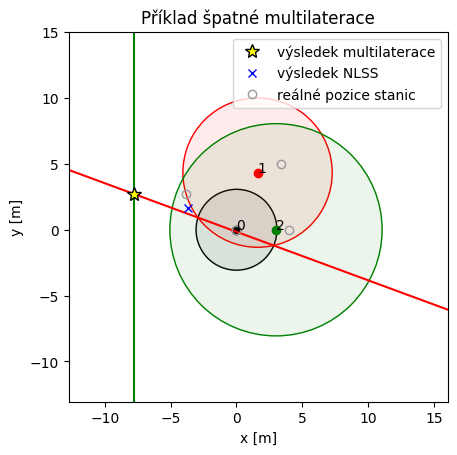

In [14]:
fig,ax = draw_multilateration_equations(anchor_outlier.iloc[-1]["chosen_anchors"], anchor_outlier.iloc[-1]["result_pos"])
lma_pos = lma(anchor_outlier.iloc[-1]["chosen_anchors"])
ax.plot(lma_pos[0], lma_pos[1], "xb", label="výsledek NLSS")
ax.plot(real.iloc[:4]["x"], real.iloc[:4]["y"], "o", fillstyle="none", color="0.6", label="reálné pozice stanic")
ax.legend()
ax.set_title("Příklad špatné multilaterace")
fig.savefig(f"{output_dir}finding-color-localization-error.png", dpi=300)

## Cesta mobilního zařízení


In [15]:
def animate(fig, ax, ln, x, y, x_limits, y_limits):
    xdata, ydata = [], []

    def init():
        ax.set_xlim(x_limits[0], x_limits[1])
        ax.set_ylim(y_limits[0], y_limits[1])
        return ln,
    
    def update(index):
        xdata.append(x.iloc[index])
        ydata.append(y.iloc[index])
        ln.set_data(xdata, ydata)
        return ln,
    
    ani = FuncAnimation(fig, update, frames=range(min(len(x), len(y))),
                        init_func=init, blit=True)
    return ani

In [16]:
def animate_path(fig, ax, ln1, ln2, data, x_limits, y_limits, trail_num=5, annotations_count=3):
    xdata1, ydata1 = [], []
    xdata2, ydata2 = [], []
    annotations = []

    def init():
        ax.set_xlim(x_limits[0], x_limits[1])
        ax.set_ylim(y_limits[0], y_limits[1])
        return ln1,ln2
    
    def update(index):
        x1 = data["result_x"].iloc[index]
        y1 = data["result_y"].iloc[index]
        x2,y2 = lma(data["chosen_anchors"].iloc[index])
        xdata1.append(x1)
        ydata1.append(y1)
        ln1.set_data(xdata1[-trail_num:],ydata1[-trail_num:])
        xdata2.append(x2)
        ydata2.append(y2)
        ln2.set_data(xdata2[-trail_num:],ydata2[-trail_num:])
        if index+1 < len(data) and data["current_color"].iloc[index] != data["current_color"].iloc[index+1]:
            ann1 = ax.annotate(f"{data["current_color"].iloc[index]}->{data["current_color"].iloc[index+1]}", (x1,y1))
            # ann2 = ax.annotate(f"{data["current_color"].iloc[index]}->{data["current_color"].iloc[index+1]}", (x2,y2))
            annotations.append(ann1)
            while len(annotations) > annotations_count:
                a1 = annotations.pop(0)
                a1.remove()
        return ln1, ln2
    
    ani = FuncAnimation(fig, update, frames=range(len(data)),
                        init_func=init, interval=400, blit=True)
    return ani

In [17]:
data_mobile = pd.read_json("logs/0011.json")
data_mobile.head()

,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos,current_color
0,42461,42691,"[{'x': 0.0, 'y': 0.0, 'dist': 12.259999}]",[],"[12.259999, 0.0]",0000fe
1,45111,45471,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[11.348564, -5.808536]",0000fe
2,48181,48601,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[10.9586, -2.603487]",0000fe
3,51251,51661,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[13.11463, -0.252683]",ffffff
4,54121,54551,"[{'x': 10.56, 'y': -1.34, 'dist': 2.08}, {'x':...","[{'x': 10.56, 'y': -1.34, 'dist': 2.08}, {'x':...","[12.704416, -1.257226]",ffffff


In [18]:
# convert "result_pos" to x and y columns
data_mobile["result_x"] = data_mobile["result_pos"].apply(lambda x: x[0])
data_mobile["result_y"] = data_mobile["result_pos"].apply(lambda x: x[1])
data_mobile.head()

,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos,current_color,result_x,result_y
0,42461,42691,"[{'x': 0.0, 'y': 0.0, 'dist': 12.259999}]",[],"[12.259999, 0.0]",0000fe,12.259999,0.000000
1,45111,45471,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[11.348564, -5.808536]",0000fe,11.348564,-5.808536
2,48181,48601,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[10.9586, -2.603487]",0000fe,10.958600,-2.603487
3,51251,51661,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[13.11463, -0.252683]",ffffff,13.114630,-0.252683
4,54121,54551,"[{'x': 10.56, 'y': -1.34, 'dist': 2.08}, {'x':...","[{'x': 10.56, 'y': -1.34, 'dist': 2.08}, {'x':...","[12.704416, -1.257226]",ffffff,12.704416,-1.257226


In [19]:
color_changes_mobile = pd.read_json("logs/0011-colors.json")
color_changes_mobile.head()

,timestamp,color
0,5051,0000fe
1,45691,0000fe
2,48711,ffffff
3,57691,0000fe
4,72601,fe0000


In [20]:
path_mobile_stations = pd.read_csv("logs/path_0011.csv")
path_mobile_stations.head(2)

,station_id,color
0,2,fe00fe
1,7,fe00fe


In [21]:
real_path_mobile = pd.merge(real, path_mobile_stations, left_on="id", right_on="station_id", how="right")
real_path_mobile.head(2)

,id,idx,x,y,comment,color_x,station_id,color_y
0,2,2,4.0,0.0,real,00ff00,2,fe00fe
1,7,6,8.4,0.0,real,ffffff,7,fe00fe


In [22]:
time_from = color_changes_mobile.iloc[6]["timestamp"]
time_to = color_changes_mobile.iloc[8]["timestamp"]
print(f"{time_from=} {time_to=}")

time_from=99201 time_to=146711


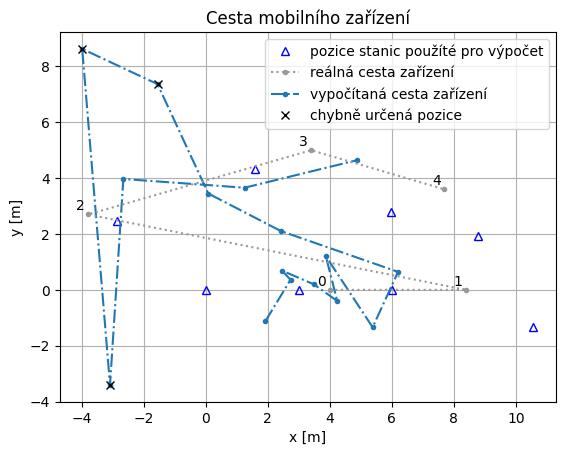

In [23]:
path_slice = data_mobile.loc[(data_mobile["timestamp_start"] >= time_from) & (data_mobile["timestamp_start"] <= time_to)]
# plt.plot(real["x"], real["y"], "o", fillstyle="none", color="0.6", label="reálné pozice stanic")
plt.plot(final["x"], final["y"], "^b", fillstyle="none", label="pozice stanic použíté pro výpočet")
plt.plot(path_slice["result_x"], path_slice["result_y"], ".-.", label="vypočítaná cesta zařízení")
plt.plot(real_path_mobile["x"], real_path_mobile["y"], ".:", color="0.6", label="reálná cesta zařízení")
plt.plot(path_slice.iloc[10:13]["result_x"], path_slice.iloc[10:13]["result_y"], "x", color="black", label="chybně určená pozice")
# for i in range(len(path_slice)):
#     plt.annotate(i, (path_slice.iloc[i]["result_x"], path_slice.iloc[i]["result_y"]))
for i in range(len(real_path_mobile)):
    plt.annotate(i, (real_path_mobile.iloc[i]["x"]-0.4, real_path_mobile.iloc[i]["y"]+0.15))
plt.gca().set_xlabel("x [m]")
plt.gca().set_ylabel("y [m]")
plt.gca().set_title("Cesta mobilního zařízení")
handles, labels = plt.gca().get_legend_handles_labels()
legend_order = [0,2,1,3]
plt.legend([handles[idx] for idx in legend_order],[labels[idx] for idx in legend_order])
plt.grid()
plt.savefig(f"{output_dir}finding-color-path.png", dpi=300)

Vizualizace špatně určených bodů okolo bodu čísla 2 v předchozím obrázku.

timestamp_start                                               128261
timestamp_end                                                 128791
anchors            [{'x': 10.56, 'y': -1.34, 'dist': 9.2}, {'x': ...
chosen_anchors     [{'x': 1.6, 'y': 4.34, 'dist': 2.9699999999999...
result_pos                                      [0.079361, 3.449264]
current_color                                                 fe00fe
result_x                                                    0.079361
result_y                                                    3.449264
Name: 29, dtype: object
A=[-1.6  -4.34], b = -11.311800000000002
(0, 2.6064055299539177), (7.069875000000001, 0), color=red
A=[-4.45 -1.87], b = -7.016450000000001
(0, 3.752112299465242), (1.5767303370786518, 0), color=green
A=[ 4.37 -1.57], b = 2.618299999999996
(0, -1.6677070063694244), (0.5991533180778024, 0), color=blue
A=[ 4.41 -4.35], b = -21.1133
(0, 4.853632183908046), (-4.787596371882086, 0), color=orange
timestamp_start               

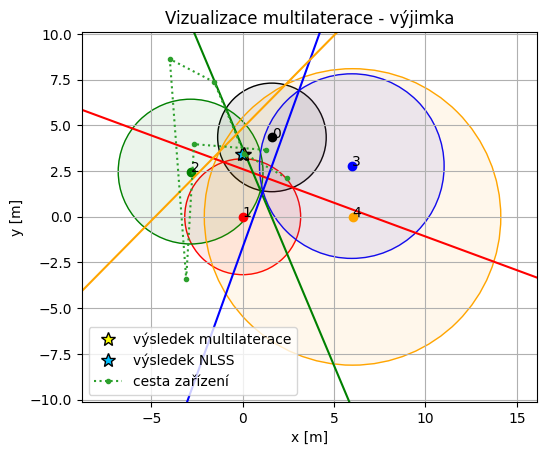

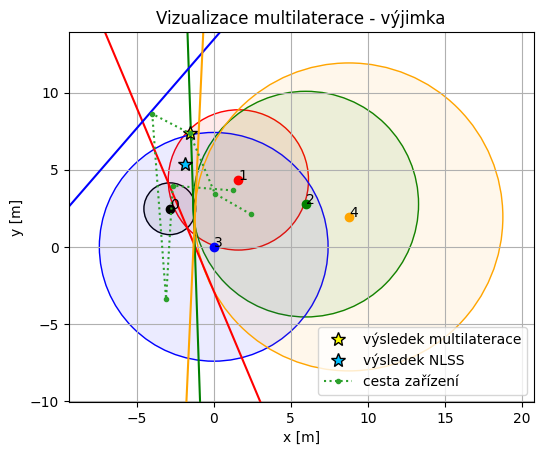

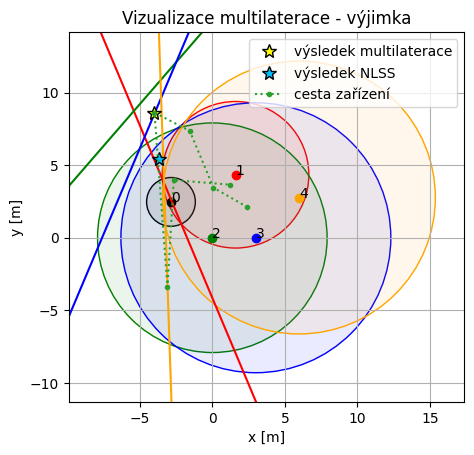

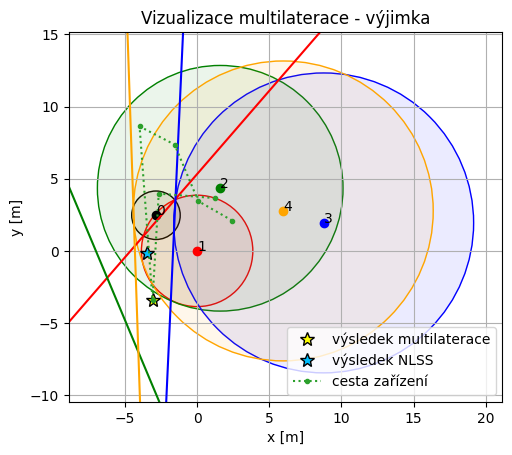

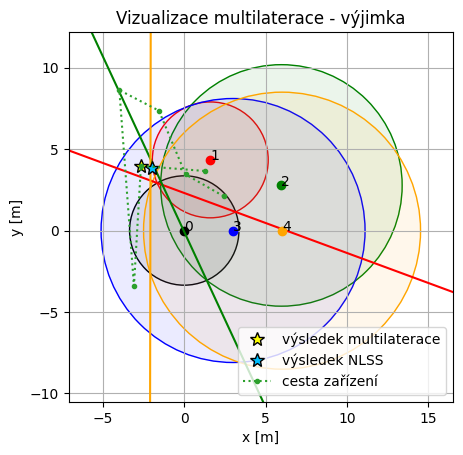

In [24]:
for i in range(9,14):
    outlier_data = path_slice.iloc[i]
    print(outlier_data)
    fig, ax = draw_multilateration_equations(outlier_data["chosen_anchors"], outlier_data["result_pos"], border=2)
    lma_pos = lma(outlier_data["chosen_anchors"])
    ax.plot(lma_pos[0], lma_pos[1], "*", label="výsledek NLSS", markersize=10, markerfacecolor="deepskyblue", markeredgewidth=1, markeredgecolor="black")
    ax.plot(path_slice.iloc[8:15]["result_x"], path_slice.iloc[8:15]["result_y"], ".:", label="cesta zařízení")
    ax.legend()
    ax.grid()
    ax.set_title("Vizualizace multilaterace - výjimka")
    # fig.savefig(f"{output_dir}finding-color-multilateration-outlier.png", dpi=300)

## Animace cesty mobilního zařízení

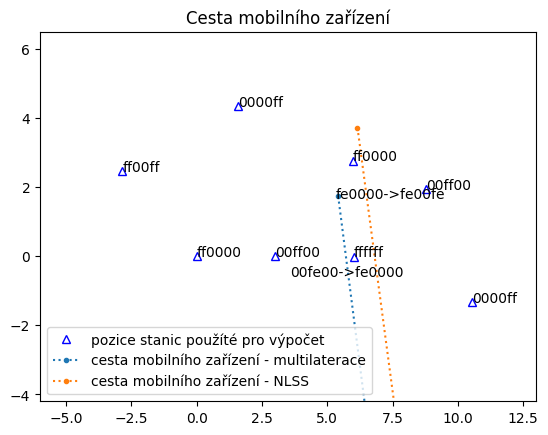

In [25]:
fig, ax = plt.subplots()
# ax.plot(real["x"], real["y"], "o", fillstyle="none", color="0.6", label="reálné pozice stanic")
ax.plot(final["x"], final["y"], "^b", fillstyle="none", label="pozice stanic použíté pro výpočet")

for i in range(len(final)):
    node = final.iloc[i]
    ax.annotate(node["color"], (node["x"], node["y"]))
ln1, = ax.plot([], [], ".:", label="cesta mobilního zařízení - multilaterace")
ln2, = ax.plot([], [], ".:", label="cesta mobilního zařízení - NLSS")
ax.legend(loc="lower left")
ax.set_title("Cesta mobilního zařízení")
ani = animate_path(fig, ax, ln1, ln2, data_mobile.iloc[1:], x_limits=[-6,13], y_limits=[-4.2,6.5], annotations_count=2)
ani.save(f"{output_dir}finding-color-mobile-path.mp4", dpi=300)

## Vizualizace špatně určených bodů

A=[4.45 1.87], b = -7.753949999999998
(0, -4.1464973262032085), (-1.7424606741573028, 0), color=red
A=[ 2.85 -2.47], b = -36.98455
(0, 14.973502024291497), (-12.977035087719297, 0), color=green
A=[ 5.85 -2.47], b = -44.4455
(0, 17.99412955465587), (-7.597521367521368, 0), color=blue
A=[8.82 0.3 ], b = -28.223600000000012
(0, -94.07866666666676), (-3.199954648526078, 0), color=orange


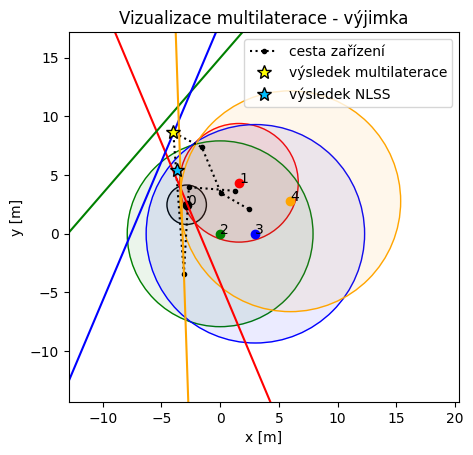

In [26]:
outlier_data = path_slice.iloc[11]
fig, ax = plt.subplots()
ax.plot(path_slice.iloc[8:15]["result_x"], path_slice.iloc[8:15]["result_y"], ".:", color="black", label="cesta zařízení")
draw_multilateration_equations(outlier_data["chosen_anchors"], outlier_data["result_pos"], fig=fig, ax=ax)
lma_pos = lma(outlier_data["chosen_anchors"])
ax.plot(lma_pos[0], lma_pos[1], "*", label="výsledek NLSS", markersize=10, markerfacecolor="deepskyblue", markeredgewidth=1, markeredgecolor="black")
ax.legend()
ax.set_title("Vizualizace multilaterace - výjimka")
fig.savefig(f"{output_dir}finding-color-multilateration-outlier.png", dpi=300)

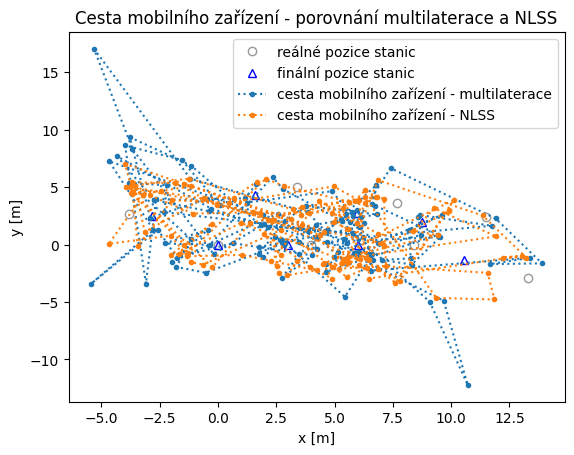

In [27]:
path_slice = data_mobile.iloc[20:-20]
lma_positions = path_slice["chosen_anchors"].apply(lma)
plt.plot(real["x"], real["y"], "o", fillstyle="none", color="0.6", label="reálné pozice stanic")
plt.plot(final["x"], final["y"], "^b", fillstyle="none", label="finální pozice stanic")
plt.plot(path_slice["result_x"], path_slice["result_y"], ".:", label="cesta mobilního zařízení - multilaterace")
plt.plot([x[0] for x in lma_positions], [x[1] for x in lma_positions], ".:", label="cesta mobilního zařízení - NLSS")
plt.gca().set_xlabel("x [m]")
plt.gca().set_ylabel("y [m]")
plt.gca().set_title("Cesta mobilního zařízení - porovnání multilaterace a NLSS")
plt.legend()
plt.savefig(f"{output_dir}finding-color-path-multilateration-nlss.png", dpi=300)

## Vizualizace druhého průchodu mobilním zařízením

Mobilní zařízení stála na vybraných bodech delší čas. Neřídilo se barvou na zařízení, pouze se testovala lokalizace

In [28]:
data_mobile2 = pd.read_json("logs/0020_2.json")
data_mobile2.head()

,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos,current_color
0,19981,20221,[],[],"[0.0, 0.0]",fe00fe
1,22651,23121,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[7.20236, -9.097501]",fe00fe
2,25621,26051,"[{'x': 10.56, 'y': -1.34, 'dist': 2.37}, {'x':...","[{'x': 6.01, 'y': -0.01, 'dist': 1.68000000000...","[6.79031, -0.432951]",fe00fe
3,28591,29131,"[{'x': 10.56, 'y': -1.34, 'dist': 13.45}, {'x'...","[{'x': 6.01, 'y': -0.01, 'dist': 1.68000000000...","[4.411424, -0.034170000000000006]",fe00fe
4,31561,32001,"[{'x': 10.56, 'y': -1.34, 'dist': 14.54}, {'x'...","[{'x': 3.0, 'y': 0.0, 'dist': 2.18}, {'x': 5.9...","[2.730997, 2.038924]",fe00fe


In [29]:
# convert "result_pos" to x and y columns
data_mobile2["result_x"] = data_mobile2["result_pos"].apply(lambda x: x[0])
data_mobile2["result_y"] = data_mobile2["result_pos"].apply(lambda x: x[1])
data_mobile2.head()

,timestamp_start,timestamp_end,anchors,chosen_anchors,result_pos,current_color,result_x,result_y
0,19981,20221,[],[],"[0.0, 0.0]",fe00fe,0.000000,0.000000
1,22651,23121,"[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[{'x': 10.56, 'y': -1.34, 'dist': 1.6800000000...","[7.20236, -9.097501]",fe00fe,7.202360,-9.097501
2,25621,26051,"[{'x': 10.56, 'y': -1.34, 'dist': 2.37}, {'x':...","[{'x': 6.01, 'y': -0.01, 'dist': 1.68000000000...","[6.79031, -0.432951]",fe00fe,6.790310,-0.432951
3,28591,29131,"[{'x': 10.56, 'y': -1.34, 'dist': 13.45}, {'x'...","[{'x': 6.01, 'y': -0.01, 'dist': 1.68000000000...","[4.411424, -0.034170000000000006]",fe00fe,4.411424,-0.034170
4,31561,32001,"[{'x': 10.56, 'y': -1.34, 'dist': 14.54}, {'x'...","[{'x': 3.0, 'y': 0.0, 'dist': 2.18}, {'x': 5.9...","[2.730997, 2.038924]",fe00fe,2.730997,2.038924


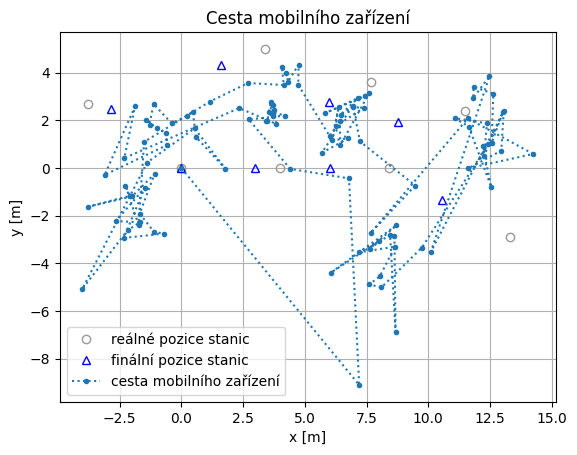

In [30]:
path_slice = data_mobile2
plt.plot(real["x"], real["y"], "o", fillstyle="none", color="0.6", label="reálné pozice stanic")
plt.plot(final["x"], final["y"], "^b", fillstyle="none", label="finální pozice stanic")
plt.plot(path_slice["result_x"], path_slice["result_y"], ".:", label="cesta mobilního zařízení")
plt.gca().set_xlabel("x [m]")
plt.gca().set_ylabel("y [m]")
plt.gca().set_title("Cesta mobilního zařízení")
plt.legend()
plt.grid()
# plt.savefig(f"{output_dir}finding-color-path.png", dpi=300)

A=[-4.37  1.57], b = -12.269099999999996
(0, -7.814713375796177), (2.8075743707093817, 0), color=red
A=[-2.97 -2.77], b = -19.372899999999998
(0, 6.993826714801443), (6.522861952861953, 0), color=green
A=[-5.97 -2.77], b = -28.749699999999997
(0, 10.378953068592057), (4.8156951423785594, 0), color=blue
A=[-8.82 -0.3 ], b = -32.40919999999999
(0, 108.0306666666667), (3.6745124716553277, 0), color=orange


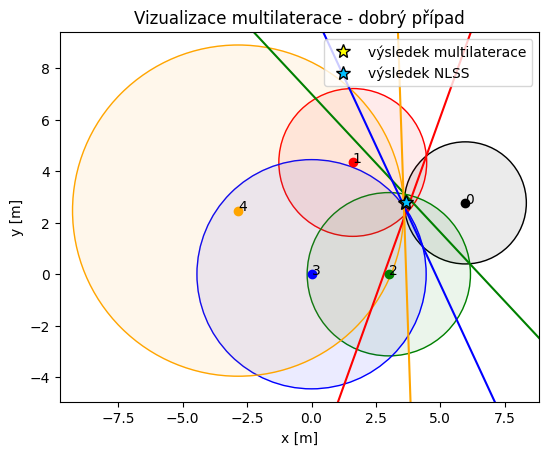

In [31]:
tmp_data = data_mobile2.iloc[11]
fig, ax = draw_multilateration_equations(tmp_data["chosen_anchors"], tmp_data["result_pos"], border=0.5)
lma_pos = lma(tmp_data["chosen_anchors"])
ax.plot(lma_pos[0], lma_pos[1], "*", label="výsledek NLSS", markersize=10, markerfacecolor="deepskyblue", markeredgewidth=1, markeredgecolor="black")
ax.legend()
ax.set_title(f"Vizualizace multilaterace - dobrý případ")
plt.show()
fig.savefig(f"{output_dir}finding-color-localization-good.png", dpi=300)